<h1>Exploring Melbourne and its suburbs to examine their food multiculturism</h1>

<h1>1. Introduction</h1>

<h3>Background</h3>
Melbourne is a multi-cultural city with almost 140 cultures represented. People from countries like China, Vietnam, Italy and Greek migrated in early years and contributed significantly to the city’s culture. Whereas, recent migrants are the large numbers of international students and IT industry employees from countries like India, Thailand, Malaysia and African countries. 
This diversity reflects in many aspects of everyday life and activities. According to City of Melbourne resident and ethnicity profiles, “56% of people who live in inner city suburbs are overseas born and 48% of people speak a language other than English at home”. These statistics show that Inner Melbourne is a multi-cultural city. To validate this statement further food scene can also be analysed. 

<h3>Problem statement</h3>
To examine Melbourne’s food choices, distribution of restaurants with cuisines of different countries. To explore which suburbs are similar in terms of food offerings by segmenting them into clusters. To validate whether availability of cuisines coincide with migrant patterns. Finally decide if Melbourne is truly a multicultural food city.

<h3>Stakeholders</h3>
This analysis can be used for business purposes and general understanding as well. Stakeholders for this analysis:

1. Companies who are in food business/individual or group of people who want to open a restaurant with a particular cuisine: They can learn about various food related factors about an area like for which cuisine the area is famous for, what other cuisines are available in the area, what are other areas similar to this area etc. This enables them to know if an area is over saturated with a type of cuisine or if there is still scope for new restaurants and choose an area. 

2. Migrants/General public: This analysis provides the overall food scene of the city. They’ll understand which suburb has which kind of restaurants. It can help them to make few decisions related to where they want to live or simply where they should go if they want to taste a cuisine.


In [1]:
# !conda install -c conda-forge geopy --yes
# !conda install -c conda-forge folium --yes

### Import everything that is necessary

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.geocoders import ArcGIS

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# 2. Data

### Data Acquisition

##### Initial Dataset: An open source dataset which had Australian cities data has been used to filter for Inner Melbourne data. Inner Melbourne has 3 cities, City of Melbourne, City of Port Phillip and City of Yarra. These 3 cities are extracted with their suburbs and postal codes. After filtering, the initial dataset to start the analysis has 3 columns. The data frame has 3 cities and 35 suburbs.

In [3]:
dfMel = pd.read_csv("australian_postalcodes.csv")
print(dfMel.shape)
dfMel.head()

(18184, 13)


,id,postcode,locality,state,long,lat,dc,type,status,sa3,sa3name,sa4,sa4name
0,1,200,ANU,ACT,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,200,Australian National University,ACT,149.11890,-35.277700,NaN,NaN,Added 19-Jan-2020,NaN,NaN,NaN,NaN
2,3,800,DARWIN,NT,130.83668,-12.458684,NaN,NaN,Updated 6-Feb-2020,70101.0,Darwin City,701.0,Darwin
3,4,801,DARWIN,NT,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,804,PARAP,NT,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Filter for inner melbourne cities, select relevant columns and rename column names

In [4]:
dfMel = dfMel[dfMel["sa4name"] == "Melbourne - Inner"].reset_index(drop=True)
dfMel = dfMel[["postcode","sa3name","locality"]]
dfMel = dfMel.rename(columns={"postcode":"Postcode","sa3name": "City", "locality": "Suburb"})
print(dfMel.shape)
dfMel.head()    

(35, 3)


,Postcode,City,Suburb
0,3000,Melbourne,CBD
1,3002,Melbourne,East Melbourne
2,3003,Melbourne,West Melbourne
3,3006,Melbourne,South Wharf
4,3006,Melbourne,Southbank


#### Add a new column to dataframe by concating all other column vales. This new column can be passed to ArcGIS for getting location coordinates.Extract Latitude and Longitude to separate columns, then take only relevant columns

In [5]:
dfMel['Location']=dfMel['Suburb']+','+dfMel['City']+' '+dfMel['Postcode'].astype(str)

#create instance of ArcGIS() for extracting coordinates
#dir(geopy)
nom=ArcGIS()

dfMel['Coordinates']=dfMel['Location'].apply(nom.geocode, timeout=10) # 'apply' is a pandas method

dfMel['Latitude'] = dfMel.apply(lambda row: row['Coordinates'].latitude, axis=1)
dfMel['Longitude'] = dfMel.apply(lambda row: row['Coordinates'].longitude, axis=1)
dfMel = dfMel[["City","Suburb","Latitude","Longitude"]]
dfMel.head()

,City,Suburb,Latitude,Longitude
0,Melbourne,CBD,-37.811100,144.970210
1,Melbourne,East Melbourne,-37.814122,144.976316
2,Melbourne,West Melbourne,-37.808868,144.955217
3,Melbourne,South Wharf,-37.825454,144.953535
4,Melbourne,Southbank,-37.820646,144.961733


##### As the code to extract coordinates acts finicky sometimes. I'm saving the file to csv and will use it further

In [6]:
dfMel.to_csv("InnerMelbourneCoords_v1.csv")

##### Reading the saved version csv dataset as the api gave an error 

In [7]:
dfMel = pd.read_csv("InnerMelbourneCoords.csv")

In [8]:
print(dfMel.shape)
dfMel.head()

(35, 4)


,City,Suburb,Latitude,Longitude
0,Melbourne,CBD,-37.812245,144.962164
1,Melbourne,East Melbourne,-37.813423,144.983535
2,Melbourne,West Melbourne,-37.807282,144.928375
3,Melbourne,South Wharf,-37.825270,144.952300
4,Melbourne,Southbank,-37.825329,144.963242


In [9]:
print('The dataframe has {} Cities and {} Suburbs.'.format(
        len(dfMel['City'].unique()),
        dfMel.shape[0]
    )
)

The dataframe has 3 Cities and 35 Suburbs.


##### Extract Melbourne coordinates using geocode

In [10]:
address = 'Melbourne, Australia'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate are {}, {}.'.format(latitude, longitude))

The geograpical coordinate are -37.8142176, 144.9631608.


##### Create Melbourne map using coordinates and folium with suburbs imposed on it

In [11]:
map_mel = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(dfMel['Latitude'], dfMel['Longitude'], dfMel['Suburb']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mel)  
    
map_mel

### Since folium maps are not rendering on GitHub. I took a screenshot of the map and added the image here. If you wish to see the dynamic map, then please copy the link of this notebook and use it on https://nbviewer.jupyter.org/

<img src="mel_map.JPG" alt="Alt text" title="Melbourne" />

In [61]:
#credentials to connect to foursquare api
CLIENT_ID = 'I removed my credential after completing the assignment' # your Foursquare ID
CLIENT_SECRET = 'I removed my credential after completing the assignment' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: I removed my credential after completing the assignment
CLIENT_SECRET:I removed my credential after completing the assignment


##### Extracting all categories and their ids from the foursquare api. We'll make use of Food category id in the further analysis to search for only food related venues

In [13]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

category_list = category_results['response']['categories']
    
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


##### Creating a function which takes the entires list we created earlier and checks for the parent id in that and returns the dictionary which has name and id of all sub categories

In [14]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [15]:
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

### Function to get all the nearby food venues. It takes the names of the suburbs, latitude and longitude as input and returns the venues, categories and their location coordinates

In [16]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

In [17]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('mel_food_venues5.pkl', 'rb') as f:
        mel_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    mel_venues = getNearbyFood(names=dfMel['Suburb'], latitudes=dfMel['Latitude'], longitudes=dfMel['Longitude'])
    with open('mel_food_venues5.pkl', 'wb') as f:
        pickle.dump(mel_venues, f)
    print("---Dataframe Created and Serialized---")

---Dataframe Existed and Deserialized---


#### This is the final dataset that we'll be working on. This has suburbs details and also venue details that are extracted from foursquare

In [18]:
print(mel_venues.shape)
mel_venues.head()

(1720, 7)


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,CBD,-37.812245,144.962164,Xing Fu Tang,-37.812206,144.962066,Bubble Tea Shop
1,CBD,-37.812245,144.962164,Starbucks,-37.811288,144.964576,Coffee Shop
2,CBD,-37.812245,144.962164,Brother Baba Budan,-37.813445,144.962137,Coffee Shop
3,CBD,-37.812245,144.962164,Emporium Café Court,-37.811925,144.963785,Food Court
4,CBD,-37.812245,144.962164,Calia,-37.812724,144.963930,Japanese Restaurant


### Data Preparation

#### List of all unique venue categories in the final dataset

In [19]:
unique_categories = mel_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Bubble Tea Shop, Coffee Shop, Food Court, Japanese Restaurant, Café, Bar, Dessert Shop, Shopping Mall, Vietnamese Restaurant, Ramen Restaurant, Persian Restaurant, Burger Joint, Beer Garden, Ice Cream Shop, Greek Restaurant, Gastropub, Thai Restaurant, Italian Restaurant, Asian Restaurant, Australian Restaurant, Dim Sum Restaurant, Pub, Bakery, Wine Bar, Mexican Restaurant, Diner, Fried Chicken Joint, Restaurant, Sandwich Place, Grocery Store, Pizza Place, BBQ Joint, Fast Food Restaurant, Argentinian Restaurant, Indian Restaurant, Turkish Restaurant, Modern European Restaurant, Hot Dog Joint, Filipino Restaurant, Juice Bar, Souvlaki Shop, Mediterranean Restaurant, Falafel Restaurant, Chinese Restaurant, Middle Eastern Restaurant, Portuguese Restaurant, Food Truck, Sushi Restaurant, Frozen Yogurt Shop, Caucasian Restaurant, Colombian Restaurant, French Restaurant, Steakhouse, Kebab Restaurant, American Restaurant, Donut Shop, Farmers Market, Cocktail Bar, Tea Room, Southern / Soul Food 

#### As the area of interest is to see the availability and distribution of various cuisines across suburbs, few venues that are irrelevant to the analysis are removed from the final dataset. For example: Common venues as Ice Cream Shop, Café, Coffee Shop, Juice Bar, Pub, Bar, Brewery

In [20]:
# list of general categories
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant','Fast Food Restaurant'
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target','Fast Food Restaurant','Deli / Bodega',
                    'Pizza Place','Fried Chicken Joint','Seafood Restaurant','Shopping Mall','BBQ Joint','Roof Deck','Steakhouse','Car Wash',
                     'Brewery','Jazz Club','Chocolate Shop','Molecular Gastronomy Restaurant']

#### Selecting only relevant unique categories by removing above listed general categories

In [21]:
# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Brazilian Restaurant, Szechuan Restaurant, Caucasian Restaurant, Indonesian Restaurant, Modern European Restaurant, Thai Restaurant, Mediterranean Restaurant, Ramen Restaurant, Cantonese Restaurant, Portuguese Restaurant, Asian Restaurant, Sushi Restaurant, Middle Eastern Restaurant, Ethiopian Restaurant, Japanese Restaurant, Colombian Restaurant, Greek Restaurant, Lebanese Restaurant, French Restaurant, Malay Restaurant, Pakistani Restaurant, Kebab Restaurant, Dim Sum Restaurant, Mexican Restaurant, Australian Restaurant, Taco Place, African Restaurant, American Restaurant, Southern / Soul Food Restaurant, German Restaurant, Vegetarian / Vegan Restaurant, Moroccan Restaurant, Sake Bar, Filipino Restaurant, Noodle House, Turkish Restaurant, Yemeni Restaurant, Hungarian Restaurant, Chinese Restaurant, Souvlaki Shop, Tapas Restaurant, Korean Restaurant, Persian Restaurant, Spanish Restaurant, Indian Restaurant, Dumpling Restaurant, Argentinian Restaurant, Falafel Restaurant, Italian Rest

# 3.Methodology Section

### Exploratory Analysis

In [22]:
mel_venues = mel_venues[mel_venues['Venue Category'].isin(food_categories)].reset_index()
print(mel_venues.shape)
mel_venues.head(5)

(493, 8)


,index,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,4,CBD,-37.812245,144.962164,Calia,-37.812724,144.963930,Japanese Restaurant
1,14,CBD,-37.812245,144.962164,Mekong Vietnamese,-37.812300,144.965040,Vietnamese Restaurant
2,15,CBD,-37.812245,144.962164,Shujinko,-37.817997,144.965127,Ramen Restaurant
3,16,CBD,-37.812245,144.962164,Arabesque,-37.803363,144.958384,Persian Restaurant
4,25,CBD,-37.812245,144.962164,Stalactites,-37.810870,144.967065,Greek Restaurant


In [23]:
print('There are {} unique FOOD categories.'.format(len(mel_venues['Venue Category'].unique())))

There are 55 unique FOOD categories.


In [24]:
print('There are {} uniques venues.'.format(len(mel_venues['Venue'].unique())))

There are 349 uniques venues.


In [25]:
# one hot encoding
mel_onehot = pd.get_dummies(mel_venues[['Venue Category']], prefix="", prefix_sep="")
mel_onehot.head()

,African Restaurant,American Restaurant,Argentinian Restaurant,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Burrito Place,Cantonese Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hungarian Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,Noodle House,Pakistani Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Sake Bar,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
# add Suburb column back to dataframe
mel_onehot['Suburb'] = mel_venues['Suburb'] 
mel_onehot.head()

,African Restaurant,American Restaurant,Argentinian Restaurant,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Burrito Place,Cantonese Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hungarian Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,Noodle House,Pakistani Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Sake Bar,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant,Suburb
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CBD
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,CBD
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CBD
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CBD
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CBD


In [27]:
# move Suburb column to the first column
Suburb = mel_onehot['Suburb']

mel_onehot.drop(labels=['Suburb'], axis=1,inplace = True)
mel_onehot.insert(0, 'Suburb', Suburb)

print(mel_onehot.shape)
mel_onehot.head()

(493, 56)


,Suburb,African Restaurant,American Restaurant,Argentinian Restaurant,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Burrito Place,Cantonese Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hungarian Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,Noodle House,Pakistani Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Sake Bar,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,CBD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CBD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,CBD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CBD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CBD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
venue_counts = mel_onehot.groupby('Suburb').sum()
venue_counts.head(5)

,African Restaurant,American Restaurant,Argentinian Restaurant,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Burrito Place,Cantonese Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hungarian Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,Noodle House,Pakistani Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Sake Bar,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
Suburb,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Abbotsford,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,5,0,1,10,0
Albert Park,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
Alphington,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2,0,1,0,3,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0
Balaclava,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,2,2,0,0
Burnley,0,0,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0


In [29]:
venue_counts_described = venue_counts.describe().transpose()

#### List of top 10 cuisines in the dataset

In [30]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Vietnamese Restaurant,35.0,1.228571,1.848461,0.0,0.0,1.0,2.0,10.0
Australian Restaurant,35.0,1.342857,1.454058,0.0,0.0,1.0,2.0,5.0
Thai Restaurant,35.0,0.971429,1.124218,0.0,0.0,1.0,1.0,5.0
Japanese Restaurant,35.0,0.942857,1.083102,0.0,0.0,1.0,1.0,5.0
Vegetarian / Vegan Restaurant,35.0,0.685714,0.963188,0.0,0.0,0.0,1.0,4.0
Italian Restaurant,35.0,1.428571,1.266903,0.0,1.0,1.0,2.0,4.0
Korean Restaurant,35.0,0.228571,0.598317,0.0,0.0,0.0,0.0,3.0
Asian Restaurant,35.0,0.428571,0.698137,0.0,0.0,0.0,1.0,3.0
Mexican Restaurant,35.0,0.514286,0.742469,0.0,0.0,0.0,1.0,3.0
Indian Restaurant,35.0,0.857143,0.943799,0.0,0.0,1.0,1.5,3.0


In [31]:
venue_top10_list = venue_top10.index.values.tolist()

#### Visualization of top 10 restaurant categories and corresponding suburbs for each one of them

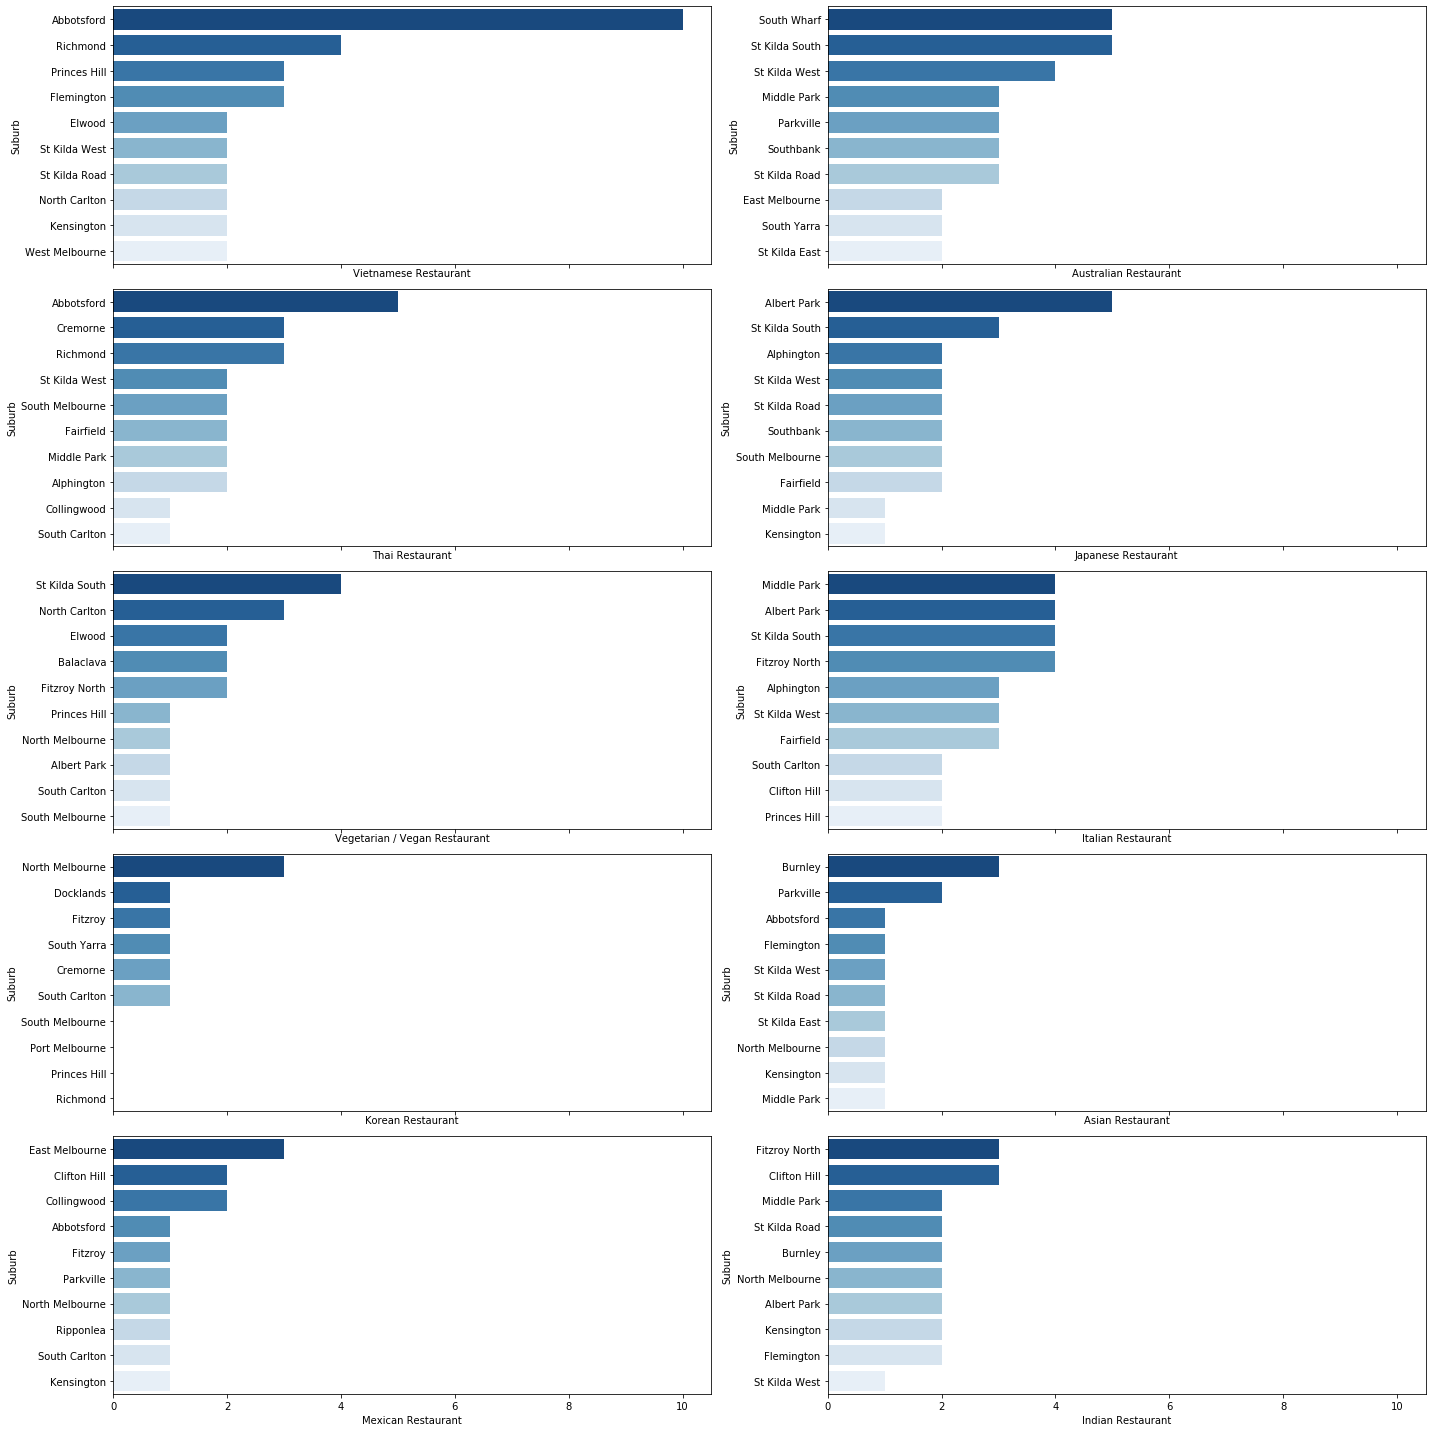

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show()

In [33]:
mel_grouped = mel_onehot.groupby('Suburb').mean().reset_index()
print(mel_grouped.shape)
mel_grouped.head()

(35, 56)


,Suburb,African Restaurant,American Restaurant,Argentinian Restaurant,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Burrito Place,Cantonese Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hungarian Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,Noodle House,Pakistani Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Sake Bar,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,Abbotsford,0.0,0.0,0.0,0.0,0.043478,0.000000,0.0,0.0,0.0,0.0,0.086957,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.043478,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.000000,0.0,0.000000,0.217391,0.000000,0.043478,0.434783,0.0
1,Albert Park,0.0,0.0,0.0,0.0,0.000000,0.066667,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.133333,0.0,0.266667,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.066667,0.0,0.000000,0.066667,0.000000,0.066667,0.000000,0.0
2,Alphington,0.0,0.0,0.0,0.0,0.000000,0.066667,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.000000,0.133333,0.0,0.066667,0.0,0.200000,0.133333,0.000000,0.0,0.066667,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.000000,0.0,0.000000,0.133333,0.000000,0.000000,0.000000,0.0
3,Balaclava,0.0,0.0,0.0,0.0,0.000000,0.083333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.083333,0.000000,0.083333,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.083333,0.0,0.083333,0.000000,0.166667,0.166667,0.000000,0.0
4,Burnley,0.0,0.0,0.0,0.0,0.214286,0.142857,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.071429,0.071429,0.0,0.142857,0.0,0.071429,0.071429,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.071429,0.0


In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1)) 

In [36]:
# create a new dataframe
Suburbs_venues_sorted = pd.DataFrame(columns=columns)
Suburbs_venues_sorted['Suburb'] = mel_grouped['Suburb']

In [37]:
for ind in np.arange(mel_grouped.shape[0]):
    Suburbs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mel_grouped.iloc[ind, :], num_top_venues)

Suburbs_venues_sorted.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abbotsford,Vietnamese Restaurant,Thai Restaurant,Chinese Restaurant,Ramen Restaurant,Asian Restaurant
1,Albert Park,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant
2,Alphington,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Greek Restaurant,Lebanese Restaurant
3,Balaclava,Vegetarian / Vegan Restaurant,Turkish Restaurant,Sushi Restaurant,Malay Restaurant,Italian Restaurant
4,Burnley,Asian Restaurant,Indian Restaurant,Australian Restaurant,Sushi Restaurant,Vietnamese Restaurant


In [38]:
mel_grouped_clustering = mel_grouped.drop('Suburb', 1)

### Machine Learning Algorithm Implementation

#### Trying to determine the optimal k value to use in clustering

In [39]:
sil = []
K_sil = range(2,12)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(mel_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(mel_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 

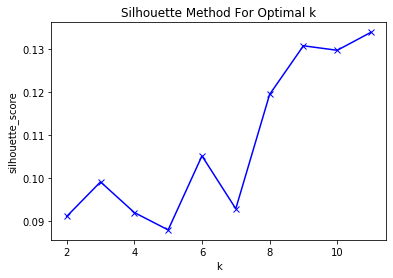

In [40]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

#### Cluster Neighborhoods

Run *k*-means to cluster the neighborhood clusters.

In [41]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mel_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(Counter(kmeans.labels_))

Counter({4: 11, 5: 9, 0: 7, 2: 4, 1: 3, 3: 1})


In [42]:
Suburbs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [43]:
# merge neighborhoods_venues_sorted with nyc_data to add latitude/longitude for each neighborhood
mel_merged = Suburbs_venues_sorted.join(dfMel.set_index('Suburb'), on='Suburb')
mel_merged.head()

,Cluster Labels,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,City,Latitude,Longitude
0,1,Abbotsford,Vietnamese Restaurant,Thai Restaurant,Chinese Restaurant,Ramen Restaurant,Asian Restaurant,Yarra,-37.803479,144.999397
1,5,Albert Park,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Port Phillip,-37.843803,144.953421
2,5,Alphington,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Greek Restaurant,Lebanese Restaurant,Yarra,-37.779806,145.029430
3,4,Balaclava,Vegetarian / Vegan Restaurant,Turkish Restaurant,Sushi Restaurant,Malay Restaurant,Italian Restaurant,Port Phillip,-37.869806,144.995274
4,5,Burnley,Asian Restaurant,Indian Restaurant,Australian Restaurant,Sushi Restaurant,Vietnamese Restaurant,Yarra,-37.829140,145.017085


# 4.Results

#### Visualize the resulting clusters

In [44]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mel_merged['Latitude'], mel_merged['Longitude'], mel_merged['Suburb'], mel_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Since folium maps are not rendering on GitHub. I took a screenshot of the map and added the image here. If you wish to see the dynamic map, then please copy the link of this notebook and use it on https://nbviewer.jupyter.org/

<img src="mel_cluster.JPG" alt="Alt text" title="Cluster Map" />

## Examine Clusters

##### Examine each cluster to see the discriminating venue categories that distinguish each cluster

#### Cluster 0: Majorily there are Indian, Mexican and Italian restaurants. We can see that Italian is the 1st common venue in South Carlton which is a known observation.

In [55]:
cluster_0 = mel_merged.loc[mel_merged['Cluster Labels'] == 0, mel_merged.columns[1:12]]
cluster_0

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,City,Latitude,Longitude
6,Clifton Hill,Indian Restaurant,Italian Restaurant,Mexican Restaurant,Moroccan Restaurant,Mediterranean Restaurant,Yarra,-37.789976,144.997655
7,Collingwood,Mexican Restaurant,Ramen Restaurant,Sushi Restaurant,Chinese Restaurant,French Restaurant,Yarra,-37.801571,144.988407
10,East Melbourne,Mexican Restaurant,Australian Restaurant,Italian Restaurant,Argentinian Restaurant,Thai Restaurant,Melbourne,-37.813423,144.983535
13,Fitzroy,Korean Restaurant,Australian Restaurant,Indian Restaurant,Mexican Restaurant,Brazilian Restaurant,Yarra,-37.800951,144.979337
14,Fitzroy North,Italian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Turkish Restaurant,Yarra,-37.782668,144.985241
19,North Melbourne,Korean Restaurant,Indian Restaurant,Italian Restaurant,Persian Restaurant,Vegetarian / Vegan Restaurant,Melbourne,-37.797653,144.946696
25,South Carlton,Italian Restaurant,Korean Restaurant,Australian Restaurant,Persian Restaurant,Indian Restaurant,Melbourne,-37.800464,144.968123


#### Cluster 1: All restaurants in this cluster and areas are offering asian cuisines. It has Vietnamese, Thai, Chinese, Sushi etc.

In [56]:
cluster_1 = mel_merged.loc[mel_merged['Cluster Labels'] == 1, mel_merged.columns[1:12]]
cluster_1

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,City,Latitude,Longitude
0,Abbotsford,Vietnamese Restaurant,Thai Restaurant,Chinese Restaurant,Ramen Restaurant,Asian Restaurant,Yarra,-37.803479,144.999397
8,Cremorne,Thai Restaurant,Sushi Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Yarra,-37.828712,144.993314
23,Richmond,Vietnamese Restaurant,Thai Restaurant,Ramen Restaurant,Dumpling Restaurant,Greek Restaurant,Yarra,-37.819961,145.002944


#### Cluster 2: This cluster is all about local Australian restaurants as it is the same 1st most common venue for all 4 locations

In [47]:
cluster_2 = mel_merged.loc[mel_merged['Cluster Labels'] == 2, mel_merged.columns[1:12]]
cluster_2

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,City,Latitude,Longitude
27,South Wharf,Australian Restaurant,Japanese Restaurant,American Restaurant,Italian Restaurant,Caucasian Restaurant,Melbourne,-37.825270,144.952300
28,South Yarra,Australian Restaurant,Korean Restaurant,Szechuan Restaurant,Vietnamese Restaurant,French Restaurant,Melbourne,-37.839645,144.993482
29,Southbank,Australian Restaurant,Japanese Restaurant,Italian Restaurant,American Restaurant,Thai Restaurant,Melbourne,-37.825329,144.963242
33,St Kilda South,Australian Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Taco Place,Port Phillip,-37.863969,144.984628


#### Cluster 3: This cluster has only 1 location with Japanese and Mexican offerings

In [57]:
cluster_3 = mel_merged.loc[mel_merged['Cluster Labels'] == 3, mel_merged.columns[1:12]]
cluster_3

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,City,Latitude,Longitude
21,Port Melbourne,Japanese Restaurant,Mexican Restaurant,Chinese Restaurant,Eastern European Restaurant,Italian Restaurant,Melbourne,-37.831073,144.924398


#### Cluster 4: This cluster is Vegetarian/Vegan and Vietnamese cuisines along with few Middle Easterns and Turkish Restaurants

In [58]:
cluster_4 = mel_merged.loc[mel_merged['Cluster Labels'] == 4, mel_merged.columns[1:12]]
cluster_4

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,City,Latitude,Longitude
3,Balaclava,Vegetarian / Vegan Restaurant,Turkish Restaurant,Sushi Restaurant,Malay Restaurant,Italian Restaurant,Port Phillip,-37.869806,144.995274
9,Docklands,Middle Eastern Restaurant,Korean Restaurant,Southern / Soul Food Restaurant,Indonesian Restaurant,Italian Restaurant,Melbourne,-37.817288,144.941729
11,Elwood,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Turkish Restaurant,Thai Restaurant,Kebab Restaurant,Port Phillip,-37.879748,144.986402
15,Flemington,Vietnamese Restaurant,Indian Restaurant,Malay Restaurant,Yemeni Restaurant,Noodle House,Melbourne,-37.785746,144.922226
16,Kensington,Indian Restaurant,Vietnamese Restaurant,Malay Restaurant,Yemeni Restaurant,Noodle House,Melbourne,-37.794373,144.927661
18,North Carlton,Vegetarian / Vegan Restaurant,Italian Restaurant,Vietnamese Restaurant,Brazilian Restaurant,Japanese Restaurant,Melbourne,-37.786889,144.970571
20,Parkville,Australian Restaurant,Asian Restaurant,Kebab Restaurant,Dumpling Restaurant,Italian Restaurant,Melbourne,-37.784998,144.950601
22,Princes Hill,Vietnamese Restaurant,Italian Restaurant,Middle Eastern Restaurant,Lebanese Restaurant,Vegetarian / Vegan Restaurant,Yarra,-37.781365,144.967041
24,Ripponlea,Australian Restaurant,Turkish Restaurant,Taco Place,Falafel Restaurant,Mexican Restaurant,Port Phillip,-37.877609,144.995697
31,St Kilda Road,Australian Restaurant,Sushi Restaurant,Indian Restaurant,Japanese Restaurant,French Restaurant,Port Phillip,-37.832085,144.974878


#### Cluster 5: This cluster has Italian and Japanese restaurants along with few Australian Restaurants

In [60]:
cluster_5 = mel_merged.loc[mel_merged['Cluster Labels'] == 5, mel_merged.columns[1:12]]
cluster_5

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,City,Latitude,Longitude
1,Albert Park,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Port Phillip,-37.843803,144.953421
2,Alphington,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Greek Restaurant,Lebanese Restaurant,Yarra,-37.779806,145.029430
4,Burnley,Asian Restaurant,Indian Restaurant,Australian Restaurant,Sushi Restaurant,Vietnamese Restaurant,Yarra,-37.829140,145.017085
5,CBD,Ramen Restaurant,Australian Restaurant,Vietnamese Restaurant,Greek Restaurant,Persian Restaurant,Melbourne,-37.812245,144.962164
12,Fairfield,Italian Restaurant,Japanese Restaurant,Thai Restaurant,Greek Restaurant,Australian Restaurant,Yarra,-37.776629,145.020456
17,Middle Park,Italian Restaurant,Australian Restaurant,Thai Restaurant,Indian Restaurant,Japanese Restaurant,Port Phillip,-37.851191,144.962768
26,South Melbourne,Japanese Restaurant,Indonesian Restaurant,Thai Restaurant,Caucasian Restaurant,Vegetarian / Vegan Restaurant,Port Phillip,-37.833600,144.957600
30,St Kilda East,Australian Restaurant,Sushi Restaurant,African Restaurant,Vietnamese Restaurant,German Restaurant,Port Phillip,-37.866437,145.004172
32,St Kilda West,Australian Restaurant,Italian Restaurant,Japanese Restaurant,Thai Restaurant,Vietnamese Restaurant,Port Phillip,-37.857714,144.971751


# 5. Discussion

From the above table we can see that it represents most regions of the world. There is Asian, Mexican, Middle Eastern, Italian and Australian. Therefore, it is safe to say that there is multi-cultural food available in Melbourne.

It also reflects the migration trends. There are significant number of Vietnamese, Japanese and Italian restaurants which coincide with the information from Melbourne city website. 

However, one interesting observation is no dominance of Chinese cuisine in the top 10 and also in the most common venues. The underlying reason for this could be, Chinese restaurants go with specific names like Sushi restaurant, Dim Sum restaurant, Asian restaurant etc. which leads to less venues per each category thus not showing a strong presence. 


# 6. Conclusion

From all the facts and figures, Melbourne is truly a food multicultural city. It has vast cuisine offerings from across the countries and regions. The analysis also reflects that food scene is going hand in hand with the earlier and current migration trends. 